In [2]:
import math

import matplotlib.pyplot as plt

show_animation = True



In [3]:
class AStarPlanner:

    def __init__(self, ox, oy, resolution, rr):
        """
        Initialize grid map for a star planning
        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.obstacle_map = None
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy)

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, gx, gy):
        """
        A star path search
        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]
        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while 1:
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[
                                                                         o]))
            current = open_set[c_id]

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(self.calc_grid_position(current.x, self.min_x),
                         self.calc_grid_position(current.y, self.min_y), "xc")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect('key_release_event',
                                             lambda event: [exit(
                                                 0) if event.key == 'escape' else None])
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Found goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node

        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position
        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = [[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion


 start!!
min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 35
y_width: 35


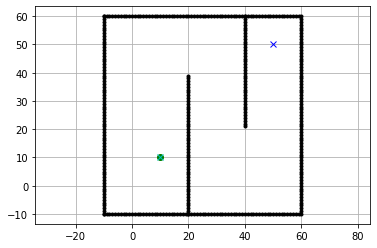

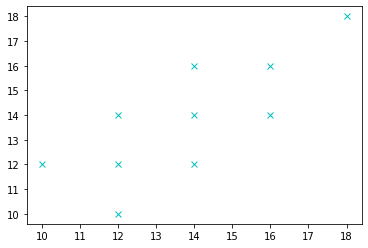

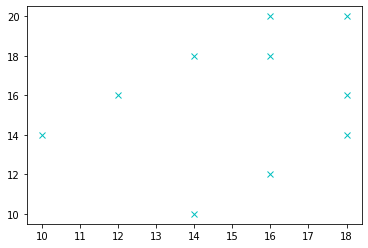

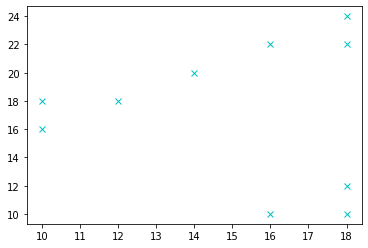

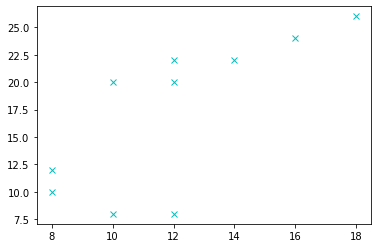

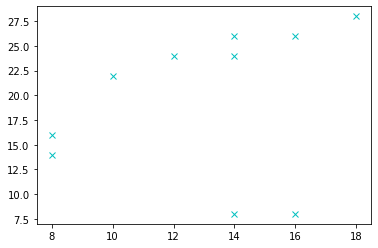

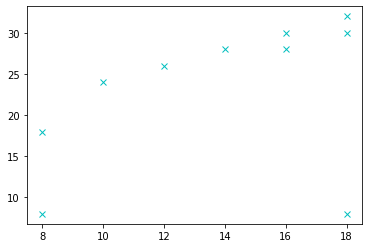

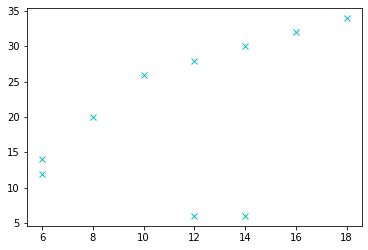

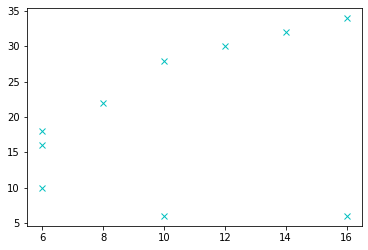

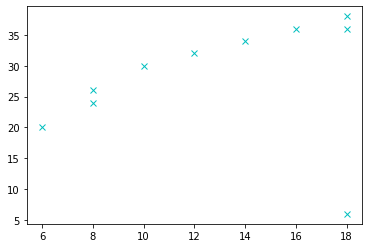

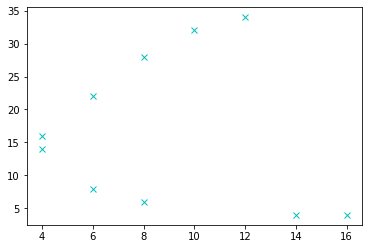

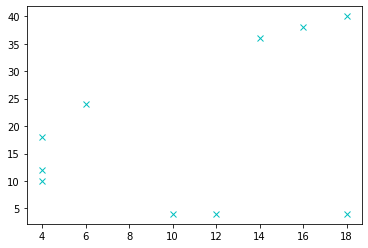

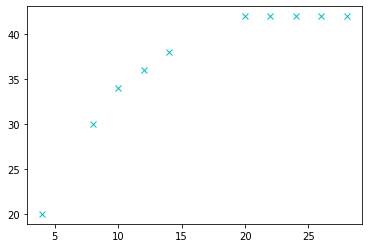

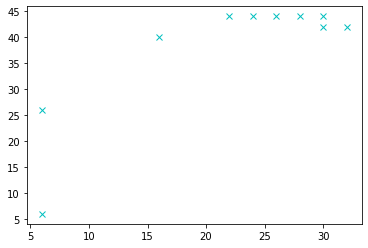

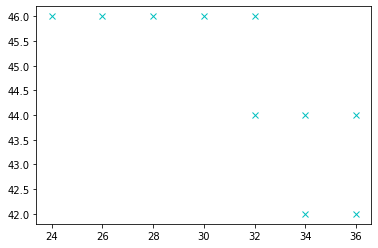

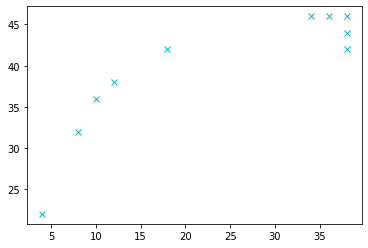

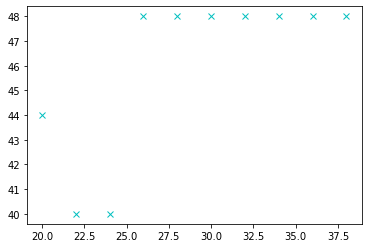

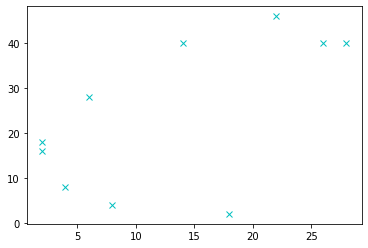

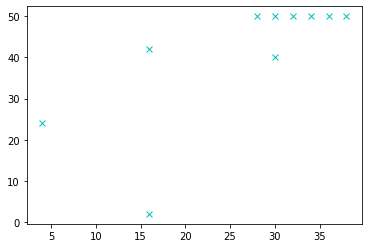

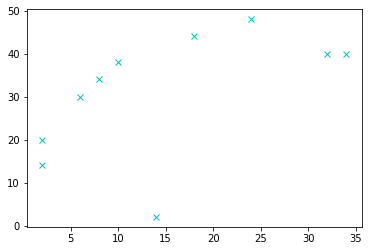

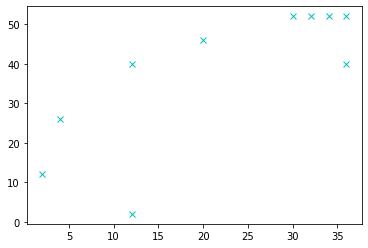

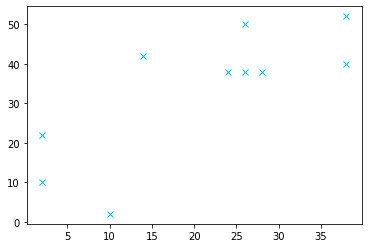

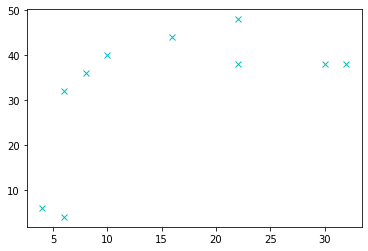

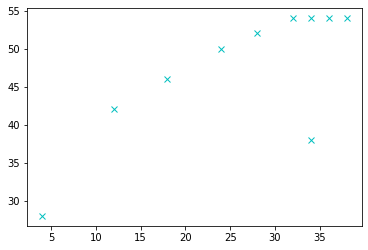

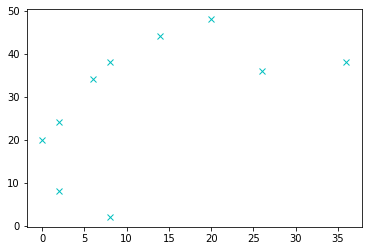

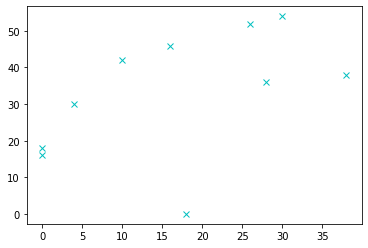

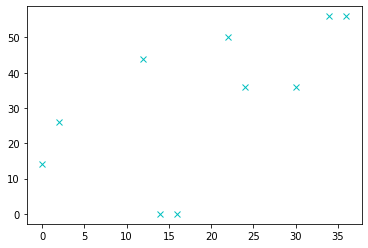

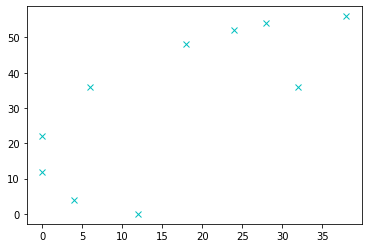

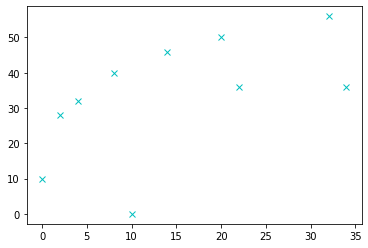

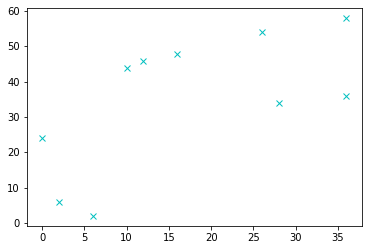

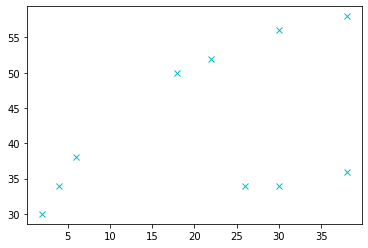

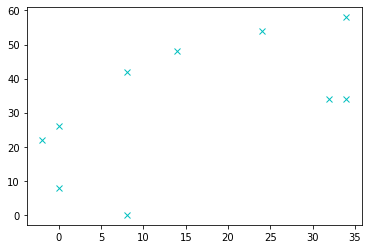

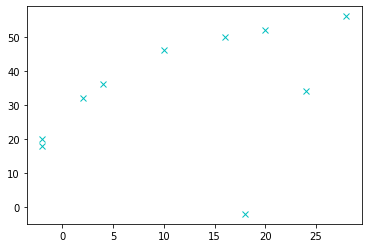

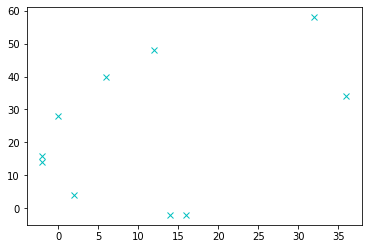

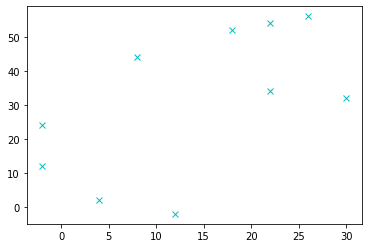

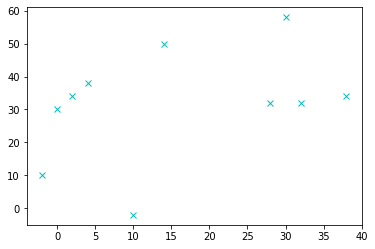

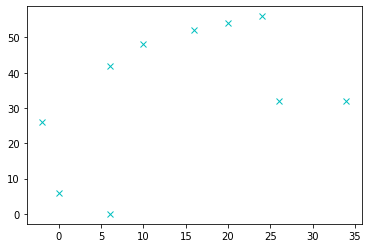

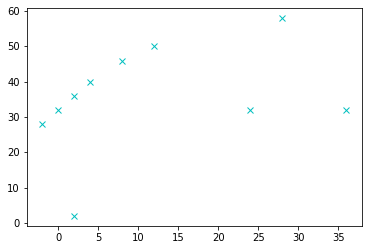

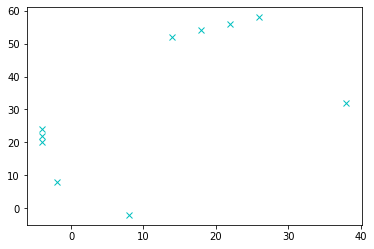

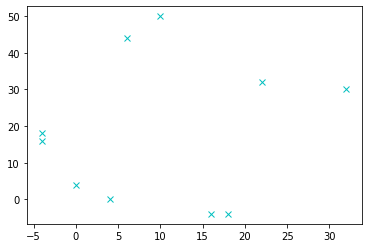

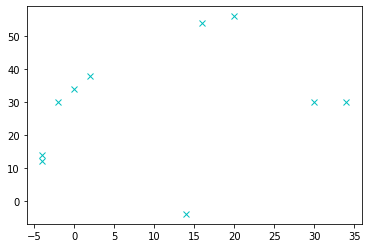

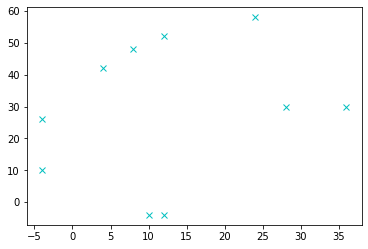

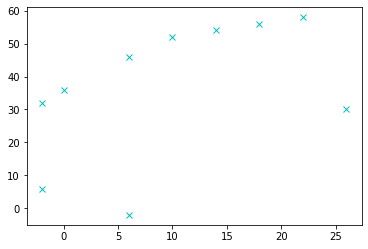

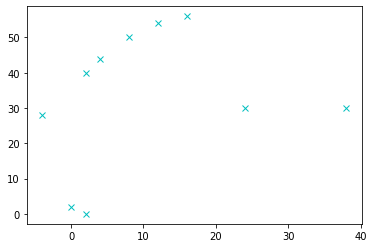

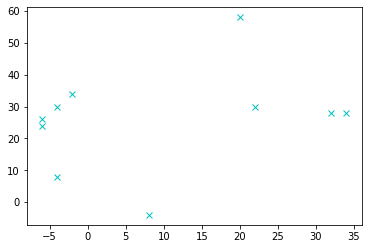

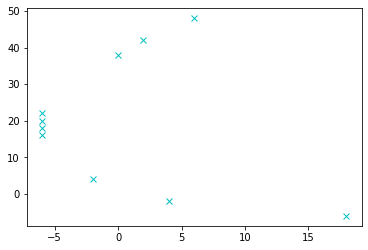

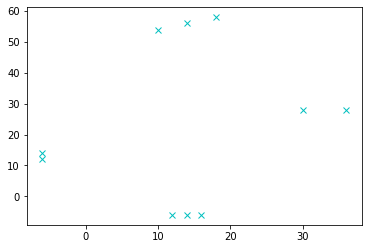

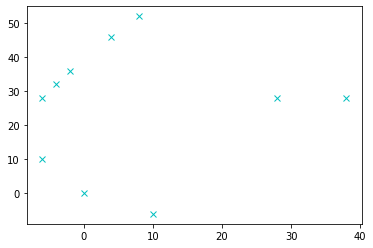

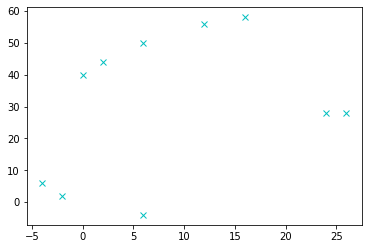

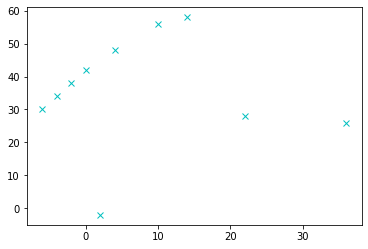

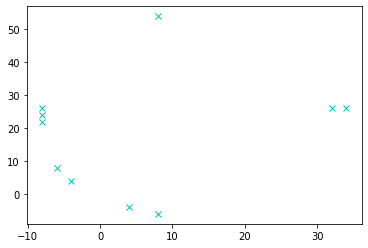

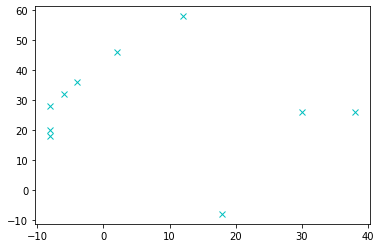

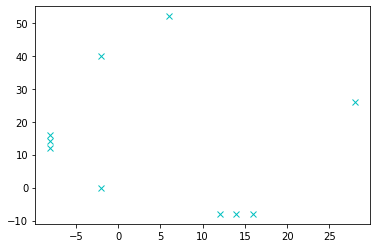

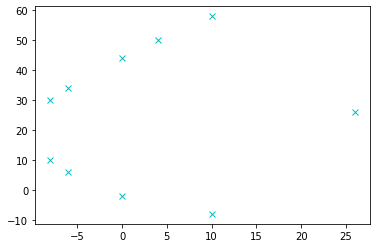

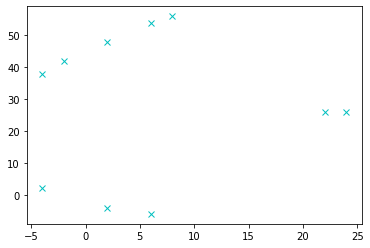

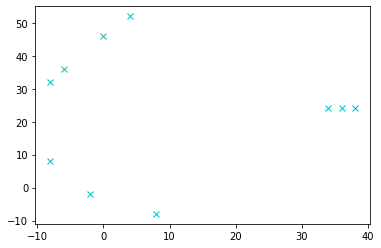

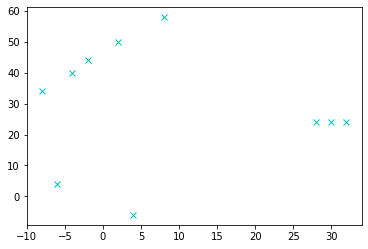

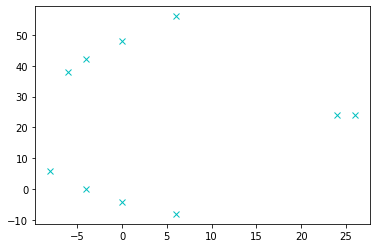

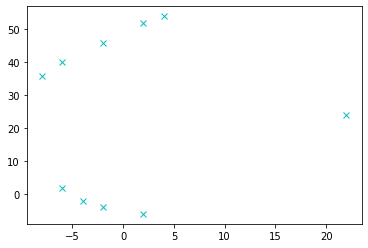

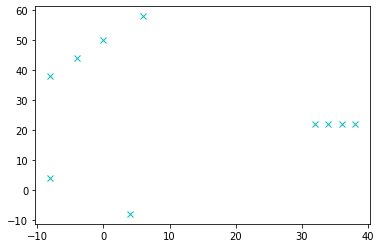

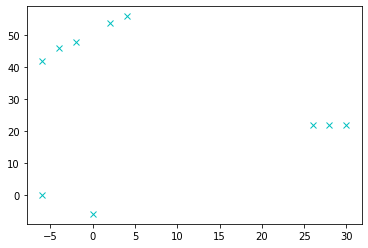

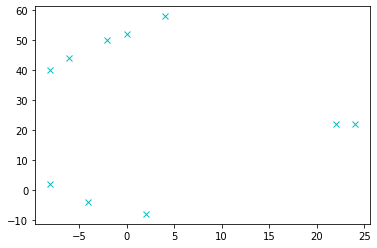

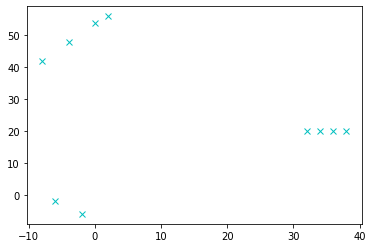

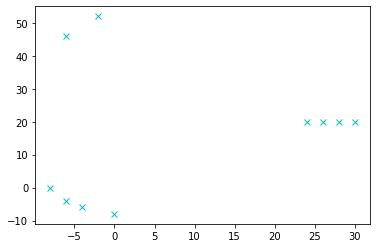

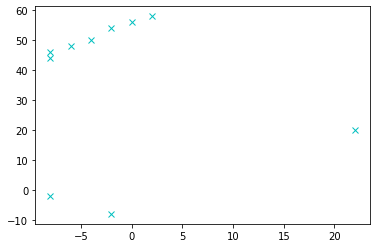

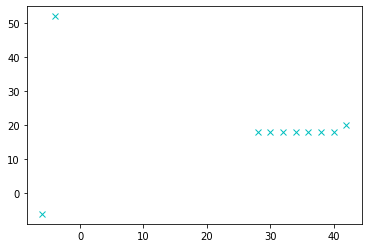

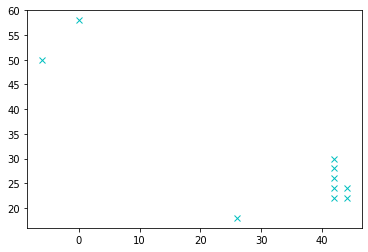

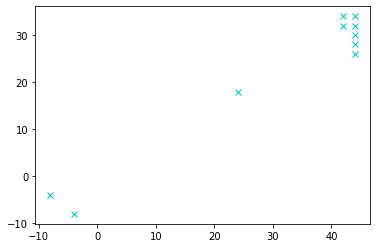

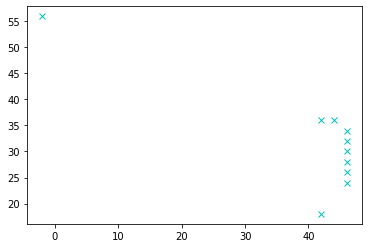

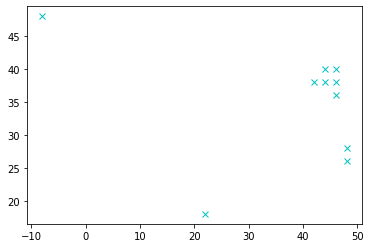

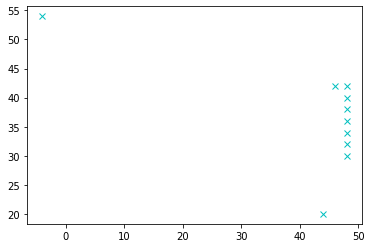

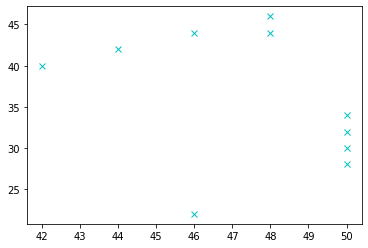

Found goal


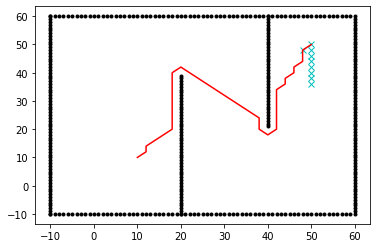

In [4]:
    print( " start!!")

    # start and goal position
    sx = 10.0  # [m]
    sy = 10.0  # [m]
    gx = 50.0  # [m]
    gy = 50.0  # [m]
    grid_size = 2.0  # [m]
    robot_radius = 1.0  # [m]

    # set obstacle positions
    ox, oy = [], []
    for i in range(-10, 60):
        ox.append(i)
        oy.append(-10.0)
    for i in range(-10, 60):
        ox.append(60.0)
        oy.append(i)
    for i in range(-10, 61):
        ox.append(i)
        oy.append(60.0)
    for i in range(-10, 61):
        ox.append(-10.0)
        oy.append(i)
    for i in range(-10, 40):
        ox.append(20.0)
        oy.append(i)
    for i in range(0, 40):
        ox.append(40.0)
        oy.append(60.0 - i)

    if show_animation:  # pragma: no cover
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "og")
        plt.plot(gx, gy, "xb")
        plt.grid(True)
        plt.axis("equal")

    a_star = AStarPlanner(ox, oy, grid_size, robot_radius)
    rx, ry = a_star.planning(sx, sy, gx, gy)

    if show_animation:  # pragma: no cover
        plt.plot(rx, ry, "-r")
        plt.plot(ox, oy, ".k")
        plt.pause(0.001)
        plt.show()
